# MNIST 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST from Hugging Face
print("Loading MNIST dataset from Hugging Face...")
dataset = load_dataset('mnist')

# Define transform to convert PIL images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

Using device: cuda
Loading MNIST dataset from Hugging Face...


In [2]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
num_train_samples = 4000  # Use only 5000 training samples instead of 60000

train_subset = dataset['train'].select(range(num_train_samples))
train_dataset = MNISTDataset(train_subset, transform=transform)
test_dataset = MNISTDataset(dataset['test'], transform=transform)

print(f"Using {len(train_dataset)} training samples (full dataset: 60000)")
print(f"Using {len(test_dataset)} test samples")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Using 4000 training samples (full dataset: 60000)
Using 10000 test samples


- n = 4000
- d = 784
- K = 10 classes
- number of parameters is (d+1)·H +(H +1)·K
- 785H+(H+1)10
- 795H+10
- 40000=795H+10
- H=39990/795=50.3 -> smaller than I thought.

In [4]:
39990/795

50.301886792452834

In [5]:
width=40
(784+1)*width+(width+1)*10

31810

- There might be some intersting visualizations of this network's weights we could do!

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, num_hidden_units=128):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, num_hidden_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(num_hidden_units, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

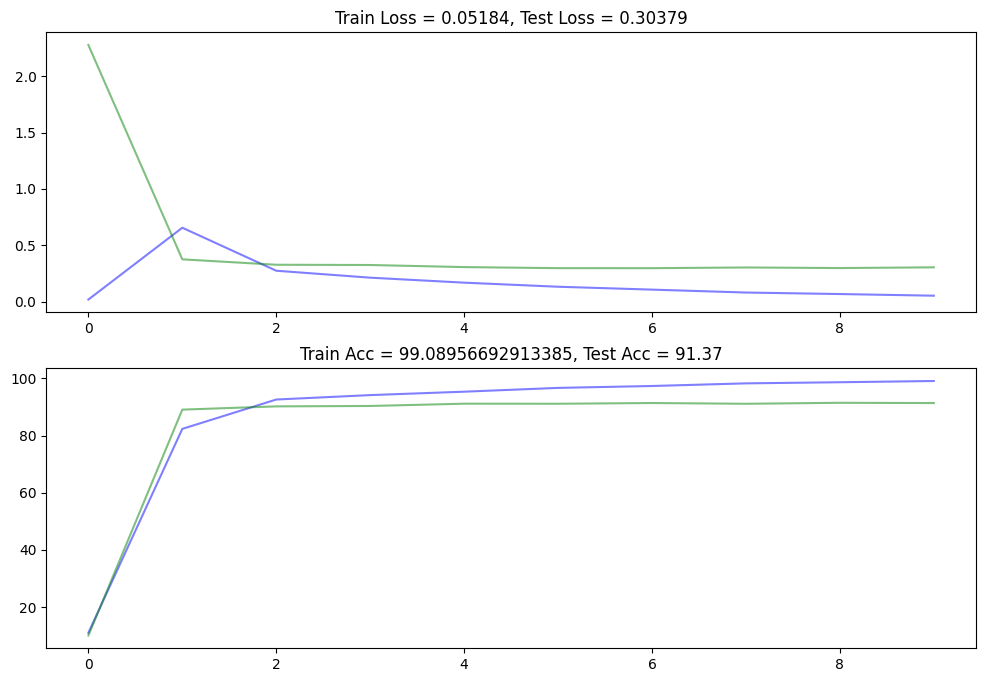

100%|████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.11s/it]


<Figure size 640x480 with 0 Axes>

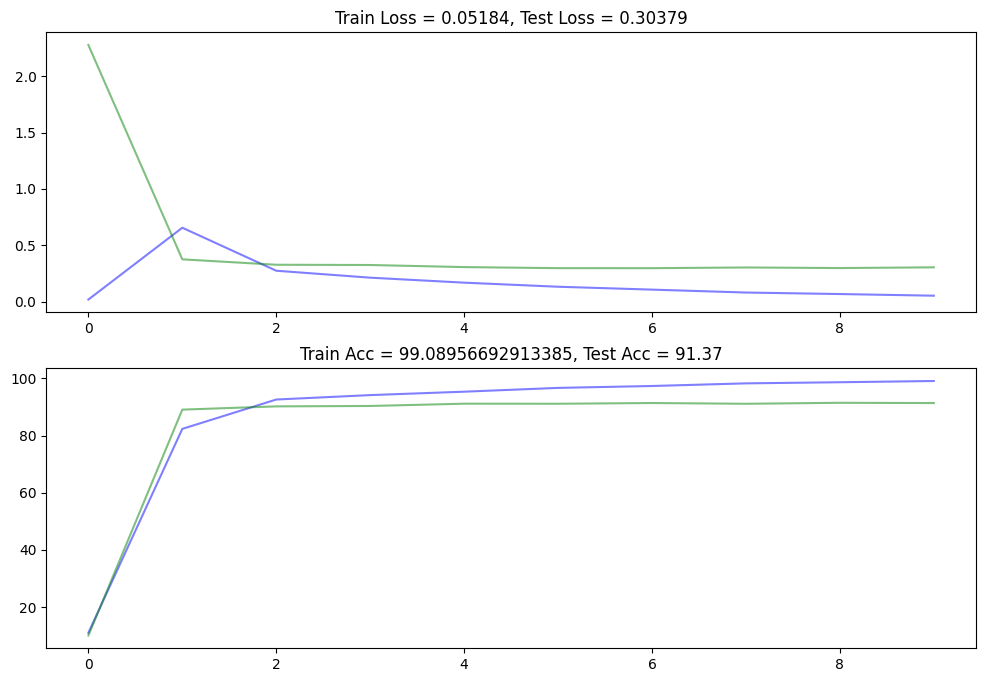

In [8]:
num_epochs=20
eval_freq=128 #Batches

train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]
#Might be cool to track weights norm as we go too?

model = SimpleNN(width).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

global_step=0
total_loss = 0
correct = 0
total = 0

for epoch in tqdm(range(num_epochs)):
    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Statistics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if global_step%eval_freq==0:
            train_accuracy.append(100. * correct / total)
            train_loss.append(total_loss / eval_freq)
            
            tl, ta = test(model, test_loader, criterion)
            test_loss.append(tl); test_accuracy.append(ta)
            
            plt.clf()
            fig=plt.figure(0, (12, 8))
            fig.add_subplot(2,1,1)
            plt.plot(train_loss, 'b', alpha=0.5)
            plt.plot(test_loss, 'g', alpha=0.5)
            plt.title('Train Loss = '+ str(round(train_loss[-1], 5))+ ', Test Loss = '+ str(round(test_loss[-1], 5)))
            fig.add_subplot(2,1,2)
            plt.plot(train_accuracy, 'b', alpha=0.5)
            plt.plot(test_accuracy, 'g', alpha=0.5) 
            plt.title('Train Acc = '+ str(train_accuracy[-1])+ ', Test Acc = '+ str(test_accuracy[-1]))
            display.clear_output(wait=True)
            display.display(plt.gcf())

            model.train()
            total_loss = 0
            correct = 0
            total = 0

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    
        global_step+=1

In [9]:
np.min(test_loss), np.max(test_accuracy), np.min(train_loss), np.max(train_accuracy)

(np.float64(0.2962702393531799),
 np.float64(91.46),
 np.float64(0.017590036615729332),
 np.float64(99.08956692913385))

---